Uncomment this if you are using Jupyter Notebook and Anaconda and ajust all relative paths to point resources you need

In [ ]:
#!pip install Pillow matplotlib tensorflow

Comment or skip this step if you are using Jupyter Notebook

In [1]:
!git clone https://github.com/vladutfyl/Licenta.git

Cloning into 'Licenta'...
remote: Enumerating objects: 174528, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 174528 (delta 0), reused 3 (delta 0), pack-reused 174525
Receiving objects: 100% (174528/174528), 925.34 MiB | 25.13 MiB/s, done.
Resolving deltas: 100% (46/46), done.
Updating files: 100% (173076/173076), done.


In [2]:
!pip install face_alignment
import face_alignment

In [3]:
!git clone https://github.com/broutonlab/face-id-with-medical-masks.git
%cd face-id-with-medical-masks

from masked_face_sdk.mask_generation_utils import end2end_mask_generation
import json

with open('data/masks_base.json', 'r') as jf:
    masks_database = json.load(jf)

Cloning into 'face-id-with-medical-masks'...
remote: Enumerating objects: 312, done.
remote: Total 312 (delta 0), reused 0 (delta 0), pack-reused 312
Receiving objects: 100% (312/312), 40.88 MiB | 31.66 MiB/s, done.
Resolving deltas: 100% (32/32), done.
/content/face-id-with-medical-masks


In [7]:
import os
from matplotlib import pyplot as plt
import numpy as np
import time
from PIL import Image, ImageDraw
# Comment nextt lines if you are using Jupyter Notebook
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
fa = face_alignment.FaceAlignment(face_alignment.LandmarksType.TWO_D, flip_input=False, device='cuda')

train_folder='../Licenta/train_dir2/'
initial_dataset='../Licenta/RMFD/self-built-masked-face-recognition-dataset/AFDB_face_dataset/'
test_folder='../Licenta/test_dir/'

Downloading: "https://www.adrianbulat.com/downloads/python-fan/s3fd-619a316812.pth" to /root/.cache/torch/hub/checkpoints/s3fd-619a316812.pth
100%|██████████| 85.7M/85.7M [00:06<00:00, 14.1MB/s]
Downloading: "https://www.adrianbulat.com/downloads/python-fan/2DFAN4-cd938726ad.zip" to /root/.cache/torch/hub/checkpoints/2DFAN4-cd938726ad.zip
100%|██████████| 91.9M/91.9M [00:07<00:00, 13.4MB/s]


In [ ]:
def open_image(image_path, required_size=(160,160),augument=False):
    img = Image.open(image_path)
    img = img.convert('RGB')
    img = img.resize(required_size)
    im = np.asarray(img)
    preds = fa.get_landmarks(im)
    if preds is None:
        return None
    if augument == True:
      im=end2end_mask_generation(im, masks_database, fa)
    return im

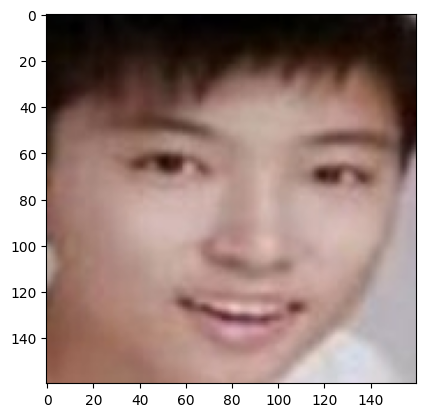

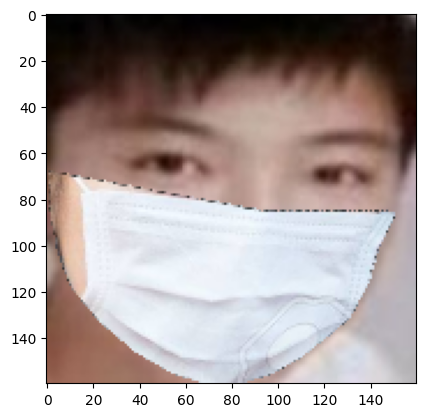

(160, 160, 3)


In [ ]:
im = open_image(initial_dataset+"zhuyuanbing/1_0_zhuyuanbing_0119.jpg")
plt.imshow(im)
plt.show()
im = open_image(initial_dataset+"zhuyuanbing/1_0_zhuyuanbing_0119.jpg",augument=True)
plt.imshow(im)
plt.show()
print(im.shape)

In [ ]:
def create_dataset(dir):
    for person in os.listdir(dir):
        start=time.time()
        person_folder=os.path.join(dir,person)
        nr=0
        os.mkdir(train_folder + person + '/')
        os.mkdir(test_folder + person +'/')
        for image_path in os.listdir(person_folder):
          nr+=1
          image = open_image(os.path.join(person_folder,image_path), augument=True)
          if image is not None:
            if nr%10 in [0,1,2]:
              new_path=test_folder + person + '/' + str(nr).rjust(5,'0') + '.jpg'
              Image.fromarray(image[:,:,:3], "RGB").save(new_path)
            else:
              new_path=train_folder + person + '/' + str(nr).rjust(5,'0') + '.jpg'
              Image.fromarray(image[:,:,:3], "RGB").save(new_path)
          else:
            print("Image {} not suitable ".format(os.path.join(person_folder,image_path)))
            nr-=1
        stop=time.time()
        t=stop-start
        print("Images for person {} were processed in {} minutes".format(person,t/60))


In [ ]:
def load_dataset(dir):
  X, y = list(), list()
  for person in os.listdir(dir):
    nr=0
    start=time.time()
    person_folder=os.path.join(dir,person)
    for image_path in os.listdir(person_folder):
      if nr<150:
        image = open_image(os.path.join(person_folder,image_path))
        if image is not None:
          X.append(image[:,:,:3])
          y.append(person)
          nr+=1
    stop=time.time()
    t=stop-start
    print("Images for person {} were processed in {} minutes".format(person,t/60))
  return np.asarray(X), np.asarray(y)


Create augumented dataset from images without mask

In [ ]:
create_dataset(initial_dataset)

Load data train and test

In [ ]:
X_train, y_train = load_dataset(train_folder)
print(X_train.shape, y_train.shape)
X_test, y_test = load_dataset(test_folder)
print(X_test.shape,y_test.shape)

In [ ]:
import dlib

detector = dlib.get_frontal_face_detector()

def align_face(faces):
  X=[]
  for image in faces:
    preds = fa.get_landmarks(image)
    points = dlib.points()
    x_max, y_max, x_min, y_min = -1 , -1, 160, 160
    for k, point in enumerate(preds[0]):
      x, y = int(point[0]), int(point[1])
      points.append(dlib.point(x, y))
      x_max = max(x_max, x)
      y_max = max(y_max, y)
      x_min = min(x_min, x)
      y_min = min(y_min, y)
    d = dlib.rectangle(top=max(0,y_min), left=max(0,x_min), right=min(160,x_max), bottom=min(160,y_min))
    obj = dlib.full_object_detection(rect=d, parts=points)
    print(obj.num_parts)
    image_new = np.zeros((image.shape[0],image.shape[1],image.shape[2]), dtype=np.uint8)
    image_new[:, :, :3]=image
    aligned_img = dlib.get_face_chip(img=image_new, face=obj)
    X.append(aligned_img)
  return X

68


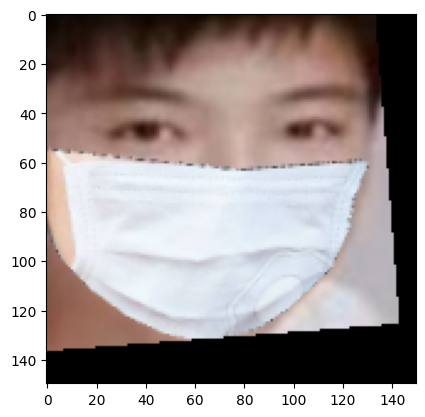

In [ ]:
[im] = align_face([im])
im = Image.fromarray(im)
plt.imshow(im)
plt.show()

Align faces

In [ ]:
X_train_align = align_face(X_train)
X_test_align =align_face(X_test)

Save preprocessed images for further use

In [ ]:
np.savez_compressed('/content/drive/MyDrive/Licenta/dataset_masked_faces_augumented_final.npz', X_train_align, y_train, X_test_align, y_test)

Load preprocessed images

In [11]:
data = np.load('/content/drive/MyDrive/Licenta/dataset_masked_faces_augumented_final.npz')
X_train, y_train, X_test, y_test = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']

In [5]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout,  Flatten, Activation, Dense
import tensorflow as tf
import numpy as np

Normalization

In [ ]:
X_train=X_train.astype(np.float16)/255
X_test=X_test.astype(np.float16)/255

In [15]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
trainy_encoded=le.fit_transform(y_train)
testy_encoded=le.transform(y_test)

In [ ]:
res = np.array(testy_encoded)
unique_res = np.unique(res)

res = np.array(trainy_encoded)
unique_res = np.unique(res)

num_classes=unique_res.shape[0]

In [ ]:
def create_weights(shape):
    return tf.Variable(tf.random.truncated_normal(shape, stddev=0.5))

def create_biases(size):
    return tf.Variable(tf.constant(0.05, shape=[size]))

In [ ]:
model = Sequential()
model.add(Convolution2D(32,(3,3),input_shape=(160,160,3),activation="relu",strides=(1, 1)))
model.add(MaxPooling2D((2,2),strides=(2,2)))

model.add(Convolution2D(64,(3,3),activation="relu",strides=(1, 1),weights=[create_weights(shape=[3, 3, 32, 64]),create_biases(64)]))
model.add(MaxPooling2D((2,2),strides=(2,2)))

model.add(Convolution2D(64,(3,3),activation="relu",strides=(1, 1)))
model.add(MaxPooling2D((2,2),strides=(2,2)))
model.add(Dropout(0.5))

model.add(Convolution2D(64,(3,3),activation="relu",strides=(1, 1)))
model.add(MaxPooling2D((2,2),strides=(2,2)))
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(2048,activation='relu'))
model.add(Dropout(0.70))
model.add(Dense(num_classes, activation='softmax'))

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model.summary()
#tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True, show_layer_activations=True, show_layer_names=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 158, 158, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 79, 79, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 77, 77, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 38, 38, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 36, 36, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 18, 18, 64)       0

In [ ]:
history = model.fit(X_train,trainy_encoded, batch_size=750, epochs=800,validation_data=(X_test,testy_encoded),verbose=2)

In [ ]:
from matplotlib import pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
model.evaluate(X_test,testy_encoded)

In [ ]:
model.save('/content/drive/MyDrive/Licenta/model_75000_batch500_ep800_acc40.h5')